In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
#LOAD DATA
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
print("Done")

Done


In [3]:
#INSPECT DATA
print("Shape of training data is"+str(train.shape))
print("Shape of training data is"+str(test.shape))

Shape of training data is(8693, 14)
Shape of training data is(4277, 13)


In [4]:
#Unequal number of columns due to 'Transported' column missing
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

Inspect data

In [5]:
train.describe(include=['object'])


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


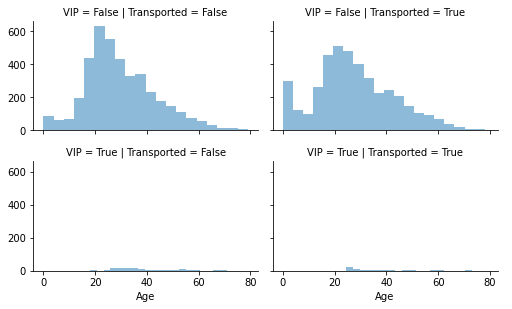

In [6]:
#DATA VISUALISATION 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

grid = sns.FacetGrid(train, col='Transported', row='VIP', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

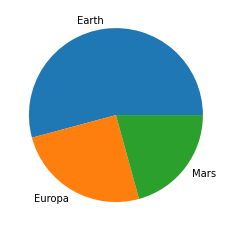

In [7]:
#The proportion size of passengers'home planet
planet_count = train["HomePlanet"].value_counts()
label=["Earth", "Europa", "Mars"]
plt.pie(planet_count, labels=label)
plt.show()

In [8]:
train.groupby(['Transported']).VIP.value_counts()
#Similar proportion of VIPs to nonVIPs for transport

Transported  VIP  
False        False    4093
             True      123
True         False    4198
             True       76
Name: VIP, dtype: int64

In [9]:
#DATA TREATMENT
#observe all NaN values in each column
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
#PassengerId has unique labels- drop
#Name has unique labels- drop
#Initial plan for Cabin is to split into different deck/num/sides but finds problem with data -To be fixed

def data_treat(df):
    
    df.drop(columns=['PassengerId','Name', 'Cabin'], inplace=True)
    
    return df
    

In [11]:
data_treat(train)
data_treat(test)
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [12]:
#Follow missing values of <10% to consider imputation
#will remove if exceeds 10%

train_cols = train.isnull().sum().to_dict()
empty_cols = []
for i,v in enumerate(train_cols):
    if train_cols[v]>(0.1*train.shape[0]):
        empty_cols.append(v)

print(f"Columns containing more than 10% missing values in dataset is {len(empty_cols)}")


Columns containing more than 10% missing values in dataset is 0


In [13]:
from sklearn import preprocessing

def feature_eng(df):
   
    le = preprocessing.LabelEncoder()
    df_obj = df.describe(include=['object'])
    #label as str type to not be categorised as float values
    df[df_obj.columns]= df[df_obj.columns].astype(str)   
    df[df_obj.columns] = df[df_obj.columns].apply(le.fit_transform)

    #Fill up NaN values with median of columns
    df = df.fillna(df.median())
    
    return df
    

In [14]:
feature_eng(train)
feature_eng(test)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0
2,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0
3,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.0,0,0.0,0.0,0.0,0.0,0.0
4273,0,0,2,42.0,0,0.0,847.0,17.0,10.0,144.0
4274,2,1,0,26.0,0,0.0,0.0,0.0,0.0,0.0
4275,1,0,3,26.0,0,0.0,2680.0,0.0,0.0,523.0


In [15]:
def int_mean(df):
    
    mean_age =round(df['Age'].mean())
    mean_rs = round(df['RoomService'].mean())
    mean_sm = round(df['ShoppingMall'].mean())
    mean_fc = round(df['FoodCourt'].mean())
    mean_spa  =round(df['Spa'].mean())
    mean_vrd = round(df['VRDeck'].mean())
    df['Age'].fillna(value=mean_age, inplace=True)
    df['RoomService'].fillna(value=mean_rs, inplace=True)
    df['ShoppingMall'].fillna(value=mean_sm, inplace=True)
    df['FoodCourt'].fillna(value=mean_fc, inplace=True)
    df['Spa'].fillna(value=mean_spa, inplace=True)
    df['VRDeck'].fillna(value=mean_vrd, inplace=True)

    return df

In [16]:
int_mean(train)
int_mean(test)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0
2,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0
3,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.0,0,0.0,0.0,0.0,0.0,0.0
4273,0,0,2,42.0,0,0.0,847.0,17.0,10.0,144.0
4274,2,1,0,29.0,0,0.0,0.0,0.0,0.0,0.0
4275,1,0,3,29.0,0,0.0,2680.0,0.0,0.0,523.0


In [17]:
#Making sure all values are filled
train.isnull().sum()


HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

Making a Dataframe of the interested variables

In [18]:
#checking for null values
test.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#DATASET PREPARATION
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1:], random_state = 0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [20]:
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 5020 to 2732
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6519 non-null   int64  
 1   CryoSleep     6519 non-null   int64  
 2   Destination   6519 non-null   int64  
 3   Age           6519 non-null   float64
 4   VIP           6519 non-null   int64  
 5   RoomService   6519 non-null   float64
 6   FoodCourt     6519 non-null   float64
 7   ShoppingMall  6519 non-null   float64
 8   Spa           6519 non-null   float64
 9   VRDeck        6519 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 560.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 3601 to 2549
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Transported  2174 non-null   bool 
dtypes: bool(1)
memory usage: 19.1 KB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Feature: HomePlanet, Score: 0.05987
Feature: CryoSleep, Score: 0.24294
Feature: Destination, Score: 0.02983
Feature: Age, Score: 0.16265
Feature: VIP, Score: 0.01074
Feature: RoomService, Score: 0.08830
Feature: FoodCourt, Score: 0.10853
Feature: ShoppingMall, Score: 0.09270
Feature: Spa, Score: 0.10322
Feature: VRDeck, Score: 0.10123


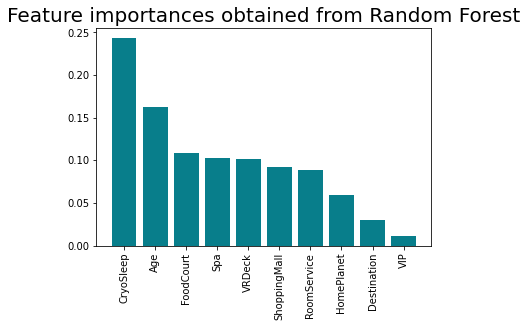

In [21]:
#IDENTIFYING IMPORTANT VARIABLES

model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

importance = model.feature_importances_

importances = pd.DataFrame(data={'Attribute':train.columns[:-1],
                                'Importance':importance
                                })

# Summarize feature importance
for i,v in enumerate(importances['Importance']):
    print('Feature: %s, Score: %.5f' % (importances['Attribute'][i],v))

importances = importances.sort_values(by='Importance', ascending=False)

#Plotting valuable features in descending order
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from Random Forest', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

fs = ['CryoSleep','Age','FoodCourt','Spa','VRDeck','ShoppingMall']

# define the model
model1 = RandomForestRegressor()

# Train with selected feature based on feature importance
model1.fit(X_train, y_train)
print("Model 1 accuracy:{:.3f}".format(model1.score(X_train, y_train)))
print("Model 1 score on prediction:{:.3f}".format(model1.score(X_test, y_test)))

model2 = DecisionTreeClassifier(random_state=1)
model2.fit(X_train, y_train)
print("Model 2 accuracy:{:.3f}".format(model2.score(X_train, y_train)))
print("Model 2 score on prediction:{:.3f}".format(model2.score(X_test,y_test)))

#DecisionTreeClassifier shows a higher accuracy- need testing for underfitting 
#model2 candidate for high bias

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Model 1 accuracy:0.799
Model 1 score on prediction:0.374
Model 2 accuracy:0.945
Model 2 score on prediction:0.707


In [23]:
# save predictions
predictions = model2.predict(test)
test_data = pd.read_csv('../input/spaceship-titanic/test.csv')
test_id = test_data.PassengerId
pd.DataFrame({"PassengerId": test_id, "Transported": predictions.astype(bool)}).to_csv('submission.csv', index=False)
